In [1]:
import sys ; sys.path.append("../")
import numpy as np
import matplotlib.pyplot as plt

from module.tools import make_bivariate_ensemble, make_samples
from module.generated_models import adv_lv, alternative_pkf_adv_lv
from module.multivariate import MultivariateEnKF1D, MultivariatePKF1D

from module.lh import *

## Importing the alternative PKF dynamics

In [4]:
class EnKF_Advection_LV(MultivariateEnKF1D, adv_lv):
    def __init__(self, **kwargs):
        adv_lv.__init__(self, **kwargs)
        MultivariateEnKF1D.__init__(self, ['A','B']) 
        
class PKF_Advection_LV(MultivariatePKF1D, alternative_pkf_adv_lv):
    def __init__(self, **kwargs):
        alternative_pkf_adv_lv.__init__(self, **kwargs)
        MultivariatePKF1D.__init__(self, ['A','B'])
        
Nx = 723
enkf = EnKF_Advection_LV(shape=(Nx,))
pkf = PKF_Advection_LV(shape=(Nx,));

NR = EnKF_Advection_LV(shape=(Nx,)) # Nature run

## Parameters of the simulation : <a class="anchor" id="simulation-parameters"></a>

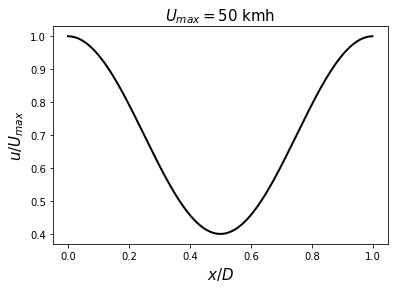

In [5]:
domain = enkf ; dx = domain.dx[0]

D = 1000  #km
u_mean = 35  #kmh
u_amp = 15 #15#kmh

u = (u_mean + u_amp*np.cos(2*np.pi*domain.x[0]))/D
Tadv = 1/u.mean()

enkf.u = u ; pkf.u = u ; NR.u = u
enkf.k_1 = 0.075; pkf.k_1 = 0.075 ; NR.k_1 = 0.075
enkf.k_2 = 0.065; pkf.k_2 = 0.065 ; NR.k_2 = 0.065
enkf.k_3 = 0.085; pkf.k_3 = 0.085 ; NR.k_3 = 0.085

dt = dx/u.max()
enkf.set_dt(dt); pkf.set_dt(dt);

species_name = ['A','B']
initial_settings = {}
nature_A = 1.2 * (1+0.1*make_samples(1, domain=domain.x[0],lh=lh)[0])
nature_B = 0.8 * (1+0.1*make_samples(1, domain=domain.x[0],lh=lh)[0])
initial_settings['Mean concentration'] = {'A':1.2,
                                          'B':0.8}
initial_settings['Std']                = {'A':0.1*1.2 ,'B':0.1*0.8}
initial_settings['Length-scale']       = {'A':lh,'B':lh}

plt.plot(domain.x[0], u/u.max(), c= 'k',linewidth=2)
plt.xlabel("$x/D$",fontsize=15);
plt.ylabel("$u/U_{max}$",fontsize=15);
plt.title('$U_{max}=$'+ f'{int(u.max()*D)} kmh',fontsize=15);

### Initializing the EnKF :

In [9]:
ensemble_size = 120
from module.tools import make_samples
print('standard deviation for the ensemble : {:.2%}'.format( (1/ensemble_size)**.5) )

ensemble0 = np.array([ initial_settings['Mean concentration'][field] +
                      make_samples(ensemble_size,
                                   domain.x[0],
                                   initial_settings['Length-scale'][field])
                      * initial_settings['Std'][field] for field in species_name]).swapaxes(0,1)

standard deviation for the ensemble : 9.13%


### Initializing the PKF :

In [10]:
mean_states0    = [initial_settings['Mean concentration'][field] + np.zeros(Nx) for field in species_name]
var0            = [initial_settings['Std'][field]**2 + np.zeros(Nx) for field in species_name]
aspect_tensors0 = [initial_settings['Length-scale'][field]**2 +np.zeros(Nx) for field in species_name]
covariance0     = [np.zeros(Nx)]
pkf_state0 = np.array(mean_states0 +  var0 + covariance0 + aspect_tensors0, dtype=np.float64)

# pkf_state0 = [mean_states0 +  var0 + covariance0 + aspect_tensors0]
# pkf_state0 = np.vstack([pkf_state0[i] + np.zeros(Nx) for i in range(len(pkf_state0))])

## Initializing the nature run :

In [11]:
NR_0 = np.array([[nature_A,nature_B]])

# 2. Five assimilation cycles <a class="anchor" id="multivariate-assimilation"></a>

we now consider the assimilation of observations on species $A$ at four locations $\mathbf{x}=0.5,0.63,0.76,0.9$.

In [12]:
assimilation_time_window = Tadv/3
n_cycles = 5

# observations configurations :
obs_std = .1
obs_network = (np.linspace(0.5,0.9,4)*Nx).astype(int)
obs_specie = 'A'
obs_species = len(obs_network)*[obs_specie]
error_obs = obs_std + 0*obs_network

#initializing the pkf and enkf :
pkf_state  = pkf_state0
enkf_state = ensemble0
NR_state = NR_0

# saving dictionnaries :
pkf_DA = {} ; enkf_DA = {}
obs_values_hist = {}
NR_save = {}
t = 0
all_times = []
for i in range(n_cycles):
    print('cycle',i)
    times = pkf.window(t + assimilation_time_window, start = t)
    all_times = all_times + list(times)
    saved_times = list(times[::4*3]) + [times[-1]]
    
    # pkf forecast 
    traj_pkf = pkf.forecast(times, pkf_state,saved_times)
    rendered_traj_pkf = pkf.render_traj(traj_pkf, obs_network, obs_species)
    
    # enkf forecast 
    traj_enkf = enkf.ensemble_forecast(times, enkf_state, saved_times)
    
    # nature run forecast
    traj_nr = NR.ensemble_forecast(times, NR_state, saved_times)
    
    t = list(rendered_traj_pkf.keys())[-1]
    
    pkf_state = traj_pkf[t] ; enkf_state = traj_enkf[t];
    NR_state = np.array(traj_nr[t])
    del traj_pkf
    diag_enkf = enkf.diagnosis(traj_enkf, obs_network, obs_species)
    del traj_enkf
    
    # collecting forecasts historic 
    pkf_DA = {**pkf_DA, **rendered_traj_pkf}
    enkf_DA = {**enkf_DA, **diag_enkf}
    NR_save = {**NR_save, **traj_nr}
    
    # generating observations
#     state_f_obs_network_enkf = diag_enkf[t]['Mean concentration'][obs_specie][obs_network]
#     state_f_obs_network_pkf = rendered_traj_pkf[t]['Mean concentration'][obs_specie][obs_network]
    nr_A_obs_loc_reality = NR_state[0,0][obs_network]
    
    obs_values =  np.maximum(0, np.random.multivariate_normal(nr_A_obs_loc_reality, np.diag(error_obs**2)))
    obs_values_hist[t] = obs_values
    
    #assimilation of the observations :
    enkf_state = enkf.assimilate(enkf_state, obs_network, obs_species, obs_values, error_obs**2)
    pkf_state = pkf.multivariate_assimilation(pkf_state, obs_values, obs_network, obs_species, error_obs**2, method='O1')
    
    #analysis diagnosis :
    rendered_pkf_a = pkf.render_traj({t:pkf_state}, obs_network, obs_species)
    diag_enkf_a = enkf.diagnosis({t:enkf_state}, obs_network, obs_species)
    
    #saving data :
    pkf_DA = {**pkf_DA, **rendered_pkf_a}
    enkf_DA = {**enkf_DA, **diag_enkf_a}

    del rendered_traj_pkf, diag_enkf;

cycle 0
cycle 1
cycle 2
cycle 3
cycle 4


# 3. Forecast <a class="anchor" id="multivariate-assimilation"></a>

In [13]:
assimilation_time_window = Tadv/3
n_cycles = 5
t_end = n_cycles * assimilation_time_window

times = pkf.window(t_end, start = .0)
saved_times = list(times)[::12] + [times[-1]]
obs_network = (np.linspace(0.5,0.9,4)*Nx).astype(int)
obs_specie = 'A'
obs_species = len(obs_network)*[obs_specie]

# pkf forecast 
traj_pkf = pkf.forecast(times, pkf_state0,saved_times)
pkf_FCST = pkf.render_traj(traj_pkf, obs_network, obs_species)

# enkf forecast 
traj_enkf = enkf.ensemble_forecast(times, ensemble0, saved_times)
enkf_FCST = enkf.diagnosis(traj_enkf, obs_network, obs_species)

# 4. Ploting

In [15]:
normalization = initial_settings

from copy import deepcopy
subplot_lims_DA = deepcopy(initial_settings)

for tf in subplot_lims_DA.keys():
    for sp in species_name : subplot_lims_DA[tf][sp] = (np.inf,-np.inf)

for t, diag in enkf_DA.items():
    for tf in subplot_lims_DA.keys():
        for sp in species_name : 
            _min, _max = subplot_lims_DA[tf][sp]
            if diag[tf][sp].min()/normalization[tf][sp] < _min: _min = diag[tf][sp].min()/normalization[tf][sp]
            if diag[tf][sp].max()/normalization[tf][sp] > _max: _max = diag[tf][sp].max()/normalization[tf][sp]
            subplot_lims_DA[tf][sp] = (_min, _max)

for tf in subplot_lims_DA.keys():
    for sp in species_name :
        _min, _max = subplot_lims_DA[tf][sp]
        amp = _max - _min
        subplot_lims_DA[tf][sp] = (_min - 0.1*amp, _max+0.1*amp)  

titles_DA = {t:r'Data assimilation with EnKF (blue, $N_e ={}$) and PKF (red), $t={:.2f}$h'.format(ensemble_size, t) for t in enkf_DA.keys()}

normalization = initial_settings

from copy import deepcopy
subplot_lims_FCST = deepcopy(initial_settings)

for tf in subplot_lims_FCST.keys():
    for sp in species_name : subplot_lims_FCST[tf][sp] = (np.inf,-np.inf)

for t, diag in enkf_FCST.items():
    for tf in subplot_lims_FCST.keys():
        for sp in species_name : 
            _min, _max = subplot_lims_FCST[tf][sp]
            if diag[tf][sp].min()/normalization[tf][sp] < _min: _min = diag[tf][sp].min()/normalization[tf][sp]
            if diag[tf][sp].max()/normalization[tf][sp] > _max: _max = diag[tf][sp].max()/normalization[tf][sp]
            subplot_lims_FCST[tf][sp] = (_min, _max)

for tf in subplot_lims_FCST.keys():
    for sp in species_name :
        _min, _max = subplot_lims_FCST[tf][sp]
        amp = _max - _min
        subplot_lims_FCST[tf][sp] = (_min - 0.1*amp, _max+0.1*amp)  


titles_FCST = {t:r'Forecast with EnKF (blue, $N_e ={}$) and PKF (red), $t={:.2f}$h'.format(ensemble_size, t) for t in enkf_FCST.keys()}

ylabels = [r'$A/A^0$',
          r'$B/B^0$',
          r'$\sigma_A/\sigma_A^0$',
          r'$\sigma_B/\sigma_B^0$',
          r'$L_A/l_h^0$',
          r'$L_B/l_h^0$']

plots_indices= [f'({c}) ' for c in 'abcdfgh']
subplots = [(3,4,1),(3,4,2),(3,4,3),(3,4,4),(3,4,7),(3,4,8),(3,4,9),(3,4,10),(3,2,6)]

keys = [ ('Mean concentration','A'),
       ('Mean concentration','B'),
       ('Std','A'),
       ('Std','B'),
       ('Length-scale','A'),
       ('Length-scale','B')]


def make_plot(t, enkf_DA, pkf_DA, assimilation_exp, subplot_lims, plot_nature_run=False, title=None,):
    fig = plt.figure(figsize=(24,12))
    if assimilation_exp :
        fig.suptitle(titles_DA[t],fontsize=15)
        assim = t in list(obs_values_hist.keys())
    else :
        fig.suptitle(titles_FCST[t],fontsize=15)
        assim = False
    
    
    if assimilation_exp and assim:
        plt.subplot(*subplots[0])
        plt.scatter(domain.x[0][obs_network],obs_values_hist[t]/normalization['Mean concentration']['A'],marker='o',c='k')
    for i, (plot_index, subplot, (key1,key2)) in enumerate(zip(plots_indices, subplots, keys)):
        plt.subplot(*subplot)
        plt.axhline(1,c='grey',alpha=0.2)
        plt.ylim(*subplot_lims[key1][key2])
        if plot_nature_run and i <2 :
            plt.plot(domain.x[0], NR_save[t][0][i]/normalization[key1][key2],c='g',label='nature run')
        
        plt.plot(domain.x[0], enkf_DA[t][key1][key2]/normalization[key1][key2], c='b',linestyle='--',label='EnKF')
        plt.plot(domain.x[0], pkf_DA[t][key1][key2]/normalization[key1][key2], c='r',linestyle='-',label='PKF')
        plt.ylabel(ylabels[i],fontsize=13)
        plt.title(key1 +' ' +key2,fontsize=14)
        if i ==0 :plt.legend(loc='upper left');
        
        if assimilation_exp:
            for loc in obs_network: plt.axvline(domain.x[0][loc], c='grey',alpha=0.3 if assim else 0.2)
        
    plt.subplot(3,2,3);plt.title('Correlation field' +r' $V^{AB}_x/(\sigma^A_x\sigma^B_x)$',fontsize=14);
    if assimilation_exp:
        for loc in obs_network: plt.axvline(domain.x[0][loc], c='grey',alpha=0.3 if assim else 0.2)
    plt.ylim(-1.1,1.1); plt.axhline(0,c='grey',alpha=0.2)
    plt.plot(domain.x[0], enkf_DA[t]['Correlation']['A']['B'], c='b',linestyle='--')
    plt.plot(domain.x[0], pkf_DA[t]['Correlation']['A']['B'], c='r',linestyle='-')
        
    plt.subplot(3,4,9);plt.title('Auto-covariance functions',fontsize=14);
    plt.axhline(1,c='grey',alpha=0.2); plt.ylabel(r"$/V_A^0$",fontsize=13)
    plt.ylim(-0.1*subplot_lims['Std']['A'][1]**2, 5.1)
    for loc in obs_network :
        plt.axvline(domain.x[0][loc], c='grey',alpha=0.3 if assim else 0.2)
        plt.plot(domain.x[0], enkf_DA[t]['Covariance functions'][loc]['A/A']/normalization['Std']['A']**2, c='b',linestyle='--')
        plt.plot(domain.x[0], pkf_DA[t]['Covariance functions'][loc]['A/A']/normalization['Std']['A']**2, c='r',linestyle='-')
    
    plt.subplot(3,4,10);plt.title('Auto-correlation functions',fontsize=14);
    plt.axhline(1,c='grey',alpha=0.2); plt.ylim(-0.1,1.1)
    for loc in obs_network :
        plt.axvline(domain.x[0][loc], c='grey',alpha=0.3 if assim else 0.2)
        plt.plot(domain.x[0], enkf_DA[t]['Correlation functions'][loc]['A/A'], c='b',linestyle='--')
        plt.plot(domain.x[0], pkf_DA[t]['Correlation functions'][loc]['A/A'], c='r',linestyle='-')
        
    plt.subplot(3,2,6);plt.title('Cross-correlation functions',fontsize=14);
    plt.axhline(0,c='grey',alpha=0.2); plt.ylim(-1.1,1.1)
    plt.axhline(-1,c='grey',alpha=0.2); plt.axhline(1,c='grey',alpha=0.2)
    for loc in obs_network :
        plt.axvline(domain.x[0][loc], c='grey',alpha=0.3 if assim else 0.2)
        plt.plot(domain.x[0], enkf_DA[t]['Correlation functions'][loc]['A/B'], c='b',linestyle='--')
        plt.plot(domain.x[0], pkf_DA[t]['Correlation functions'][loc]['A/B'], c='r',linestyle='-')
    
    fig.tight_layout();
    return fig

## 4.1 making videos

### forecast experiment

In [18]:
from model.ploting_functions.utils import *

times = list(enkf_FCST.keys())

saving_dir = '../plots/'
img_name= f'alternative_pkf_formulation_forecast_Nx{Nx}'

ploting_args = (enkf_FCST,pkf_FCST,False,subplot_lims_FCST,None,)

save_plots(saving_dir, img_name, make_plot, times, titles_FCST, ploting_args)

make_video(imgs_dir = saving_dir, output_dir='../video_plots/',
           output_filename = img_name,fps = 12)

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

### data assimilation experiment

In [19]:
from model.ploting_functions.utils import *

times = list(enkf_DA.keys())

saving_dir = '../plots/'
img_name= f'alternative_pkf_formulation_data_assimilation_experiment_Nx{Nx}'

ploting_args = (enkf_DA,pkf_DA,True,subplot_lims_DA,True, None,)

save_plots(saving_dir, img_name, make_plot, times, titles_DA, ploting_args)

make_video(imgs_dir = saving_dir, output_dir='../video_plots/',
           output_filename = img_name,fps = 12)

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

## 4.2 Static plot for the article

In [20]:
subplots2 = [(2,4,1),(2,4,2),(2,4,3),(2,4,4),(2,4,7),(2,4,8)]
panel_indexs = [f'({c}) ' for c in 'abcdfg']
def make_plot2(times, alphas,enkf_hist, pkf_hist, assimilation_exp,subplot_lims,plot_nature_run=False, title=None):
    fig = plt.figure(figsize=(20,9))
    if title : fig.suptitle(title, fontsize=15)
#   
    for t,alpha in zip(times,alphas) :
        if assimilation_exp :
            assim = t in list(obs_values_hist.keys())
        else : 
            assim = False
            
        if assim and assimilation_exp:
            plt.subplot(*subplots2[0])
            plt.scatter(domain.x[0][obs_network],obs_values_hist[t]/normalization['Mean concentration']['A'],
                        alpha=alpha,marker='o',c='k')
        for i, (plot_index, subplot, (key1,key2),panel_index) in enumerate(zip(plots_indices, subplots2, keys,panel_indexs)):
            plt.subplot(*subplot)
            plt.axhline(1,c='grey',alpha=0.2)
            plt.ylim(*subplot_lims[key1][key2])
            time_label = r'$t$={:.1f}'.format(alpha) +r'$t_{max}$'
            if plot_nature_run and i <2 :
                plt.plot(domain.x[0], NR_save[t][0][i]/normalization[key1][key2],c='g', alpha=alpha,zorder=0.2)
            
            plt.plot(domain.x[0], enkf_hist[t][key1][key2]/normalization[key1][key2], c='b',linestyle='--',alpha=alpha,label='EnKF ' + time_label)
            plt.plot(domain.x[0], pkf_hist[t][key1][key2]/normalization[key1][key2], c='r',linestyle='-',alpha=alpha,label='PKF   ' + time_label)
            plt.ylabel(ylabels[i],fontsize=13)
            plt.title(panel_index + key1 +' ' +key2,fontsize=14)
            if i ==0 : plt.legend(loc='upper left')
            if assimilation_exp:
                for loc in obs_network: plt.axvline(domain.x[0][loc], c='grey',alpha=0.3 if assim else 0.2)

        plt.subplot(2,2,3);plt.title('(e) Correlation field '+r'$V^{AB}_x/(\sigma^A_x\sigma^B_x)$',fontsize=14);
        if assimilation_exp:
            for loc in obs_network: plt.axvline(domain.x[0][loc], c='grey',alpha=0.3 if assim else 0.2)
        plt.ylim(-1.1,1.1); plt.axhline(0,c='grey',alpha=0.2)
        plt.plot(domain.x[0], enkf_hist[t]['Correlation']['A']['B'], c='b',linestyle='--',alpha=alpha)
        plt.plot(domain.x[0], pkf_hist[t]['Correlation']['A']['B'], c='r',linestyle='-',alpha=alpha)
        
    fig.tight_layout();
    return fig

In [27]:
n_stops = 2

times = list(enkf_FCST.keys())
indexs = np.linspace(0, len(times)-1,n_stops+1).astype(int)[1:]

times2 = [times[index] for index in indexs]
alphas = [0.5,1]

### Forecast experiment

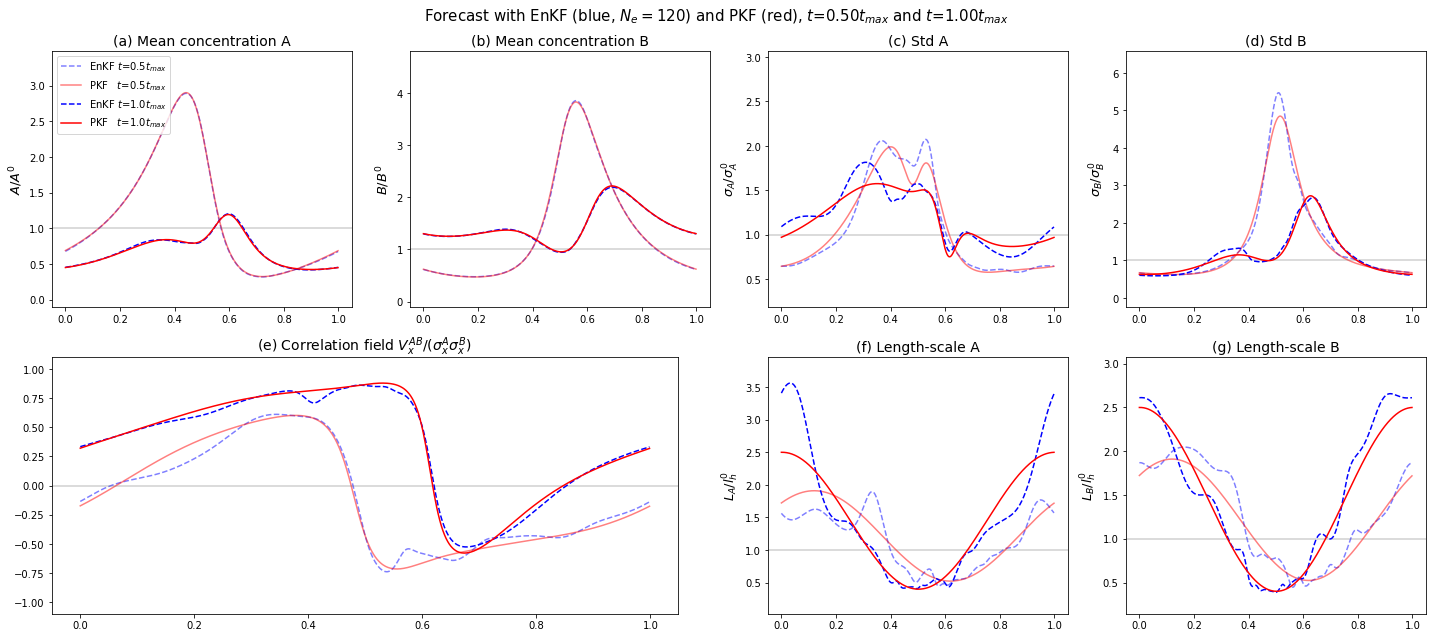

In [29]:
title_FCST = r'Forecast with EnKF (blue, $N_e ={}$) and PKF (red), $t$={:.2f}'.format(ensemble_size, times2[0]/times[-1]) +\
    r'$t_{max}$' +' and $t$={:.2f}'.format(times2[1]/times[-1]) \
    + r'$t_{max}$'
fig_FCST = make_plot2(times2[:2],alphas, enkf_FCST, pkf_FCST,False,subplot_lims_FCST, False, title_FCST);
fig_FCST.savefig(f'../../figures/Nx{Nx}/alternative_pkf_formulation_forecast_Nx{Nx}.png')

### Data assimilation experiment

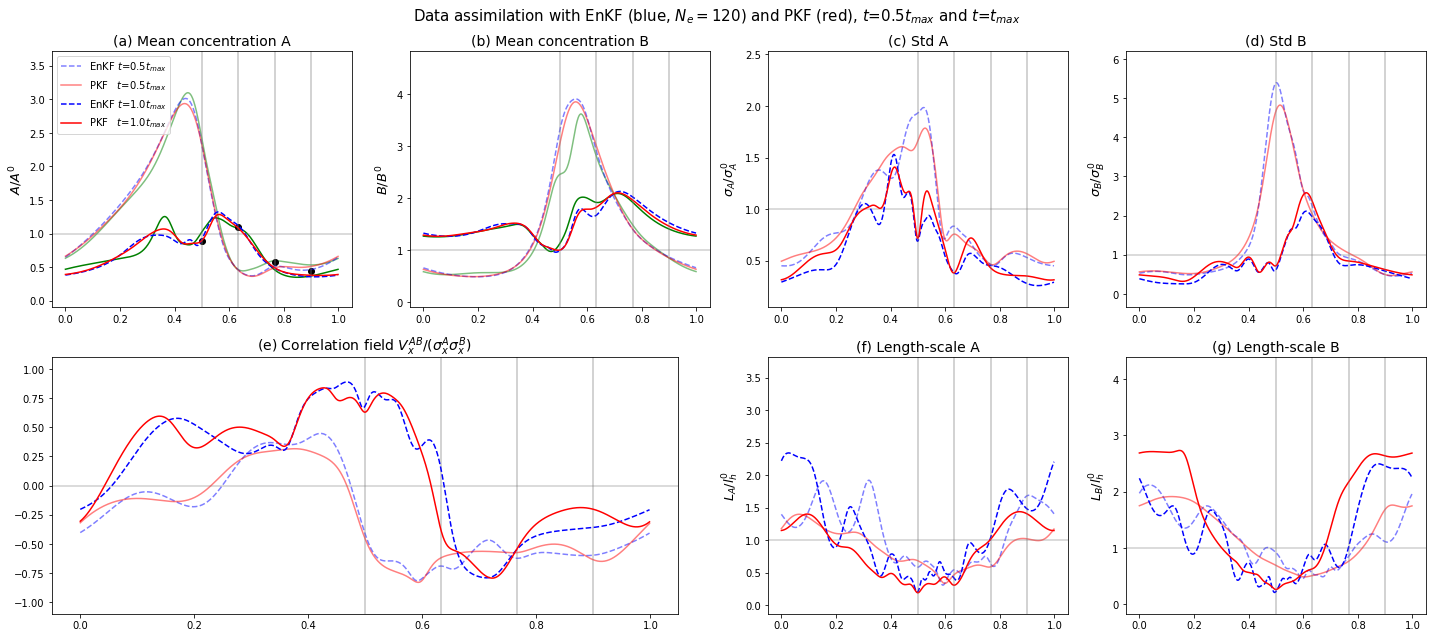

In [24]:
title_DA = r'Data assimilation with EnKF (blue, $N_e ={}$) and PKF (red), $t$={:.1f}'.format(ensemble_size, times2[0]/times[-1]) +\
    r'$t_{max}$' +' and $t$='.format(times2[1]/times[-1]) \
    + r'$t_{max}$'
fig_DA = make_plot2(times2[:2],alphas,enkf_DA, pkf_DA, True,subplot_lims_DA,True, title_DA);
fig_DA.savefig(f'../../figures/Nx{Nx}/alternative_pkf_formulation_data_assimilation_exp_Nx{Nx}_with_NR.png')

# ....

# Heterogeneous case

We perform the same experiment as previously, except we consider heterogeneous initial length-scales

In [30]:
initial_settings['Length-scale']  = {'A':lhA,'B':lhB}

### Initializing the EnKF :

In [31]:
ensemble_size = 120
from module.tools import make_samples
print('standard deviation for the ensemble : {:.2%}'.format( (1/ensemble_size)**.5) )

ensemble0 = np.array([ initial_settings['Mean concentration'][field] +
                      make_samples(ensemble_size,
                                   domain.x[0],
                                   initial_settings['Length-scale'][field])
                      * initial_settings['Std'][field] for field in species_name]).swapaxes(0,1)

standard deviation for the ensemble : 9.13%


### Initializing the PKF :

In [32]:
mean_states0    = [initial_settings['Mean concentration'][field] + np.zeros(Nx) for field in species_name]
var0            = [initial_settings['Std'][field]**2 + np.zeros(Nx) for field in species_name]
aspect_tensors0 = [initial_settings['Length-scale'][field]**2 +np.zeros(Nx) for field in species_name]
covariance0     = [np.zeros(Nx)]
pkf_state0 = np.array(mean_states0 +  var0 + covariance0 + aspect_tensors0, dtype=np.float64)

# pkf_state0 = [mean_states0 +  var0 + covariance0 + aspect_tensors0]
# pkf_state0 = np.vstack([pkf_state0[i] + np.zeros(Nx) for i in range(len(pkf_state0))])

## Initializing the nature run :

In [33]:
NR_0 = np.array([[nature_A,nature_B]])

# 2. Five assimilation cycles <a class="anchor" id="multivariate-assimilation"></a>

we now consider the assimilation of observations on species $A$ at four locations $\mathbf{x}=0.5,0.63,0.76,0.9$.

In [34]:
assimilation_time_window = Tadv/3
n_cycles = 5

# observations configurations :
obs_std = .1
obs_network = (np.linspace(0.5,0.9,4)*Nx).astype(int)
obs_specie = 'A'
obs_species = len(obs_network)*[obs_specie]
error_obs = obs_std + 0*obs_network

#initializing the pkf and enkf :
pkf_state  = pkf_state0
enkf_state = ensemble0
NR_state = NR_0

# saving dictionnaries :
pkf_DA = {} ; enkf_DA = {}
obs_values_hist = {}
NR_save = {}
t = 0
all_times = []
for i in range(n_cycles):
    print('cycle',i)
    times = pkf.window(t + assimilation_time_window, start = t)
    all_times = all_times + list(times)
    saved_times = list(times[::4*3]) + [times[-1]]
    
    # pkf forecast 
    traj_pkf = pkf.forecast(times, pkf_state,saved_times)
    rendered_traj_pkf = pkf.render_traj(traj_pkf, obs_network, obs_species)
    
    # enkf forecast 
    traj_enkf = enkf.ensemble_forecast(times, enkf_state, saved_times)
    
    # nature run forecast
    traj_nr = NR.ensemble_forecast(times, NR_state, saved_times)
    
    t = list(rendered_traj_pkf.keys())[-1]
    
    pkf_state = traj_pkf[t] ; enkf_state = traj_enkf[t];
    NR_state = np.array(traj_nr[t])
    del traj_pkf
    diag_enkf = enkf.diagnosis(traj_enkf, obs_network, obs_species)
    del traj_enkf
    
    # collecting forecasts historic 
    pkf_DA = {**pkf_DA, **rendered_traj_pkf}
    enkf_DA = {**enkf_DA, **diag_enkf}
    NR_save = {**NR_save, **traj_nr}
    
    # generating observations
#     state_f_obs_network_enkf = diag_enkf[t]['Mean concentration'][obs_specie][obs_network]
#     state_f_obs_network_pkf = rendered_traj_pkf[t]['Mean concentration'][obs_specie][obs_network]
    nr_A_obs_loc_reality = NR_state[0,0][obs_network]
    
    obs_values =  np.maximum(0, np.random.multivariate_normal(nr_A_obs_loc_reality, np.diag(error_obs**2)))
    obs_values_hist[t] = obs_values
    
    #assimilation of the observations :
    enkf_state = enkf.assimilate(enkf_state, obs_network, obs_species, obs_values, error_obs**2)
    pkf_state = pkf.multivariate_assimilation(pkf_state, obs_values, obs_network, obs_species, error_obs**2, method='O1')
    
    #analysis diagnosis :
    rendered_pkf_a = pkf.render_traj({t:pkf_state}, obs_network, obs_species)
    diag_enkf_a = enkf.diagnosis({t:enkf_state}, obs_network, obs_species)
    
    #saving data :
    pkf_DA = {**pkf_DA, **rendered_pkf_a}
    enkf_DA = {**enkf_DA, **diag_enkf_a}

    del rendered_traj_pkf, diag_enkf;

cycle 0
cycle 1
cycle 2
cycle 3
cycle 4


# 3. Forecast <a class="anchor" id="multivariate-assimilation"></a>

In [35]:
assimilation_time_window = Tadv/3
n_cycles = 5
t_end = n_cycles * assimilation_time_window

times = pkf.window(t_end, start = .0)
saved_times = list(times)[::12] + [times[-1]]
obs_network = (np.linspace(0.5,0.9,4)*Nx).astype(int)
obs_specie = 'A'
obs_species = len(obs_network)*[obs_specie]

# pkf forecast 
traj_pkf = pkf.forecast(times, pkf_state0,saved_times)
pkf_FCST = pkf.render_traj(traj_pkf, obs_network, obs_species)

# enkf forecast 
traj_enkf = enkf.ensemble_forecast(times, ensemble0, saved_times)
enkf_FCST = enkf.diagnosis(traj_enkf, obs_network, obs_species)

# 4. Ploting

In [36]:
normalization = initial_settings

from copy import deepcopy
subplot_lims_DA = deepcopy(initial_settings)

for tf in subplot_lims_DA.keys():
    for sp in species_name : subplot_lims_DA[tf][sp] = (np.inf,-np.inf)

for t, diag in enkf_DA.items():
    for tf in subplot_lims_DA.keys():
        for sp in species_name : 
            _min, _max = subplot_lims_DA[tf][sp]
            if diag[tf][sp].min()/normalization[tf][sp] < _min: _min = diag[tf][sp].min()/normalization[tf][sp]
            if diag[tf][sp].max()/normalization[tf][sp] > _max: _max = diag[tf][sp].max()/normalization[tf][sp]
            subplot_lims_DA[tf][sp] = (_min, _max)

for tf in subplot_lims_DA.keys():
    for sp in species_name :
        _min, _max = subplot_lims_DA[tf][sp]
        amp = _max - _min
        subplot_lims_DA[tf][sp] = (_min - 0.1*amp, _max+0.1*amp)  

titles_DA = {t:r'Data assimilation with EnKF (blue, $N_e ={}$) and PKF (red), $l^0_A \neq l^0_B $, $t={:.2f}$h'.format(ensemble_size, t) for t in enkf_DA.keys()}

normalization = initial_settings

from copy import deepcopy
subplot_lims_FCST = deepcopy(initial_settings)

for tf in subplot_lims_FCST.keys():
    for sp in species_name : subplot_lims_FCST[tf][sp] = (np.inf,-np.inf)

for t, diag in enkf_FCST.items():
    for tf in subplot_lims_FCST.keys():
        for sp in species_name : 
            _min, _max = subplot_lims_FCST[tf][sp]
            if diag[tf][sp].min()/normalization[tf][sp] < _min: _min = diag[tf][sp].min()/normalization[tf][sp]
            if diag[tf][sp].max()/normalization[tf][sp] > _max: _max = diag[tf][sp].max()/normalization[tf][sp]
            subplot_lims_FCST[tf][sp] = (_min, _max)

for tf in subplot_lims_FCST.keys():
    for sp in species_name :
        _min, _max = subplot_lims_FCST[tf][sp]
        amp = _max - _min
        subplot_lims_FCST[tf][sp] = (_min - 0.1*amp, _max+0.1*amp)  


titles_FCST = {t:r'Forecast with EnKF (blue, $N_e ={}$) and PKF (red), $l^0_A \neq l^0_B $, $t={:.2f}$h'.format(ensemble_size, t) for t in enkf_FCST.keys()}

ylabels = [r'$A/A^0$',
          r'$B/B^0$',
          r'$\sigma_A/\sigma_A^0$',
          r'$\sigma_B/\sigma_B^0$',
          r'$L_A/l_h^0$',
          r'$L_B/l_h^0$']

plots_indices= [f'({c}) ' for c in 'abcdfgh']
subplots = [(3,4,1),(3,4,2),(3,4,3),(3,4,4),(3,4,7),(3,4,8),(3,4,9),(3,4,10),(3,2,6)]

keys = [ ('Mean concentration','A'),
       ('Mean concentration','B'),
       ('Std','A'),
       ('Std','B'),
       ('Length-scale','A'),
       ('Length-scale','B')]


def make_plot(t, enkf_DA, pkf_DA, assimilation_exp, subplot_lims, plot_nature_run=False, title=None,):
    fig = plt.figure(figsize=(24,12))
    if assimilation_exp :
        fig.suptitle(titles_DA[t],fontsize=15)
        assim = t in list(obs_values_hist.keys())
    else :
        fig.suptitle(titles_FCST[t],fontsize=15)
        assim = False
    
    
    if assimilation_exp and assim:
        plt.subplot(*subplots[0])
        plt.scatter(domain.x[0][obs_network],obs_values_hist[t]/normalization['Mean concentration']['A'],marker='o',c='k')
    for i, (plot_index, subplot, (key1,key2)) in enumerate(zip(plots_indices, subplots, keys)):
        plt.subplot(*subplot)
        plt.axhline(1,c='grey',alpha=0.2)
        plt.ylim(*subplot_lims[key1][key2])
        if plot_nature_run and i <2 :
            plt.plot(domain.x[0], NR_save[t][0][i]/normalization[key1][key2],c='g',label='nature run')
        
        plt.plot(domain.x[0], enkf_DA[t][key1][key2]/normalization[key1][key2], c='b',linestyle='--',label='EnKF')
        plt.plot(domain.x[0], pkf_DA[t][key1][key2]/normalization[key1][key2], c='r',linestyle='-',label='PKF')
        plt.ylabel(ylabels[i],fontsize=13)
        plt.title(key1 +' ' +key2,fontsize=14)
        if i ==0 :plt.legend(loc='upper left');
        
        if assimilation_exp:
            for loc in obs_network: plt.axvline(domain.x[0][loc], c='grey',alpha=0.3 if assim else 0.2)
        
    plt.subplot(3,2,3);plt.title('Correlation field' +r' $V^{AB}_x/(\sigma^A_x\sigma^B_x)$',fontsize=14);
    if assimilation_exp:
        for loc in obs_network: plt.axvline(domain.x[0][loc], c='grey',alpha=0.3 if assim else 0.2)
    plt.ylim(-1.1,1.1); plt.axhline(0,c='grey',alpha=0.2)
    plt.plot(domain.x[0], enkf_DA[t]['Correlation']['A']['B'], c='b',linestyle='--')
    plt.plot(domain.x[0], pkf_DA[t]['Correlation']['A']['B'], c='r',linestyle='-')
        
    plt.subplot(3,4,9);plt.title('Auto-covariance functions',fontsize=14);
    plt.axhline(1,c='grey',alpha=0.2); plt.ylabel(r"$/V_A^0$",fontsize=13)
    plt.ylim(-0.1*subplot_lims['Std']['A'][1]**2, 5.1)
    for loc in obs_network :
        plt.axvline(domain.x[0][loc], c='grey',alpha=0.3 if assim else 0.2)
        plt.plot(domain.x[0], enkf_DA[t]['Covariance functions'][loc]['A/A']/normalization['Std']['A']**2, c='b',linestyle='--')
        plt.plot(domain.x[0], pkf_DA[t]['Covariance functions'][loc]['A/A']/normalization['Std']['A']**2, c='r',linestyle='-')
    
    plt.subplot(3,4,10);plt.title('Auto-correlation functions',fontsize=14);
    plt.axhline(1,c='grey',alpha=0.2); plt.ylim(-0.1,1.1)
    for loc in obs_network :
        plt.axvline(domain.x[0][loc], c='grey',alpha=0.3 if assim else 0.2)
        plt.plot(domain.x[0], enkf_DA[t]['Correlation functions'][loc]['A/A'], c='b',linestyle='--')
        plt.plot(domain.x[0], pkf_DA[t]['Correlation functions'][loc]['A/A'], c='r',linestyle='-')
        
    plt.subplot(3,2,6);plt.title('Cross-correlation functions',fontsize=14);
    plt.axhline(0,c='grey',alpha=0.2); plt.ylim(-1.1,1.1)
    plt.axhline(-1,c='grey',alpha=0.2); plt.axhline(1,c='grey',alpha=0.2)
    for loc in obs_network :
        plt.axvline(domain.x[0][loc], c='grey',alpha=0.3 if assim else 0.2)
        plt.plot(domain.x[0], enkf_DA[t]['Correlation functions'][loc]['A/B'], c='b',linestyle='--')
        plt.plot(domain.x[0], pkf_DA[t]['Correlation functions'][loc]['A/B'], c='r',linestyle='-')
    
    fig.tight_layout();
    return fig

## 4.1 making videos

### forecast experiment

In [39]:
from model.ploting_functions.utils import *

times = list(enkf_FCST.keys())

saving_dir = '../plots/'
img_name= f'alternative_pkf_formulation_forecast_Nx{Nx}_l0A_neq_l0B'

ploting_args = (enkf_FCST,pkf_FCST,False,subplot_lims_FCST,None,)

save_plots(saving_dir, img_name, make_plot, times, titles_FCST, ploting_args)

make_video(imgs_dir = saving_dir, output_dir='../video_plots/',
           output_filename = img_name,fps = 12)

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

### data assimilation experiment

In [40]:
from model.ploting_functions.utils import *

times = list(enkf_DA.keys())

saving_dir = '../plots/'
img_name= f'alternative_pkf_formulation_data_assimilation_experiment_Nx{Nx}_l0A_neq_l0B'

ploting_args = (enkf_DA,pkf_DA,True,subplot_lims_DA,True, None,)

save_plots(saving_dir, img_name, make_plot, times, titles_DA, ploting_args)

make_video(imgs_dir = saving_dir, output_dir='../video_plots/',
           output_filename = img_name,fps = 12)

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

## 4.2 Static plot for the article

In [41]:
subplots2 = [(2,4,1),(2,4,2),(2,4,3),(2,4,4),(2,4,7),(2,4,8)]
panel_indexs = [f'({c}) ' for c in 'abcdfg']
def make_plot2(times, alphas,enkf_hist, pkf_hist, assimilation_exp,subplot_lims,plot_nature_run=False, title=None):
    fig = plt.figure(figsize=(20,9))
    if title : fig.suptitle(title, fontsize=15)
#   
    for t,alpha in zip(times,alphas) :
        if assimilation_exp :
            assim = t in list(obs_values_hist.keys())
        else : 
            assim = False
            
        if assim and assimilation_exp:
            plt.subplot(*subplots2[0])
            plt.scatter(domain.x[0][obs_network],obs_values_hist[t]/normalization['Mean concentration']['A'],
                        alpha=alpha,marker='o',c='k')
        for i, (plot_index, subplot, (key1,key2),panel_index) in enumerate(zip(plots_indices, subplots2, keys,panel_indexs)):
            plt.subplot(*subplot)
            plt.axhline(1,c='grey',alpha=0.2)
            plt.ylim(*subplot_lims[key1][key2])
            time_label = r'$t$={:.1f}'.format(alpha) +r'$t_{max}$'
            if plot_nature_run and i <2 :
                plt.plot(domain.x[0], NR_save[t][0][i]/normalization[key1][key2],c='g', alpha=alpha,zorder=0.2)
            
            plt.plot(domain.x[0], enkf_hist[t][key1][key2]/normalization[key1][key2], c='b',linestyle='--',alpha=alpha,label='EnKF ' + time_label)
            plt.plot(domain.x[0], pkf_hist[t][key1][key2]/normalization[key1][key2], c='r',linestyle='-',alpha=alpha,label='PKF   ' + time_label)
            plt.ylabel(ylabels[i],fontsize=13)
            plt.title(panel_index + key1 +' ' +key2,fontsize=14)
            if i ==0 : plt.legend(loc='upper left')
            if assimilation_exp:
                for loc in obs_network: plt.axvline(domain.x[0][loc], c='grey',alpha=0.3 if assim else 0.2)

        plt.subplot(2,2,3);plt.title('(e) Correlation field '+r'$V^{AB}_x/(\sigma^A_x\sigma^B_x)$',fontsize=14);
        if assimilation_exp:
            for loc in obs_network: plt.axvline(domain.x[0][loc], c='grey',alpha=0.3 if assim else 0.2)
        plt.ylim(-1.1,1.1); plt.axhline(0,c='grey',alpha=0.2)
        plt.plot(domain.x[0], enkf_hist[t]['Correlation']['A']['B'], c='b',linestyle='--',alpha=alpha)
        plt.plot(domain.x[0], pkf_hist[t]['Correlation']['A']['B'], c='r',linestyle='-',alpha=alpha)
        
    fig.tight_layout();
    return fig

### Forecast experiment

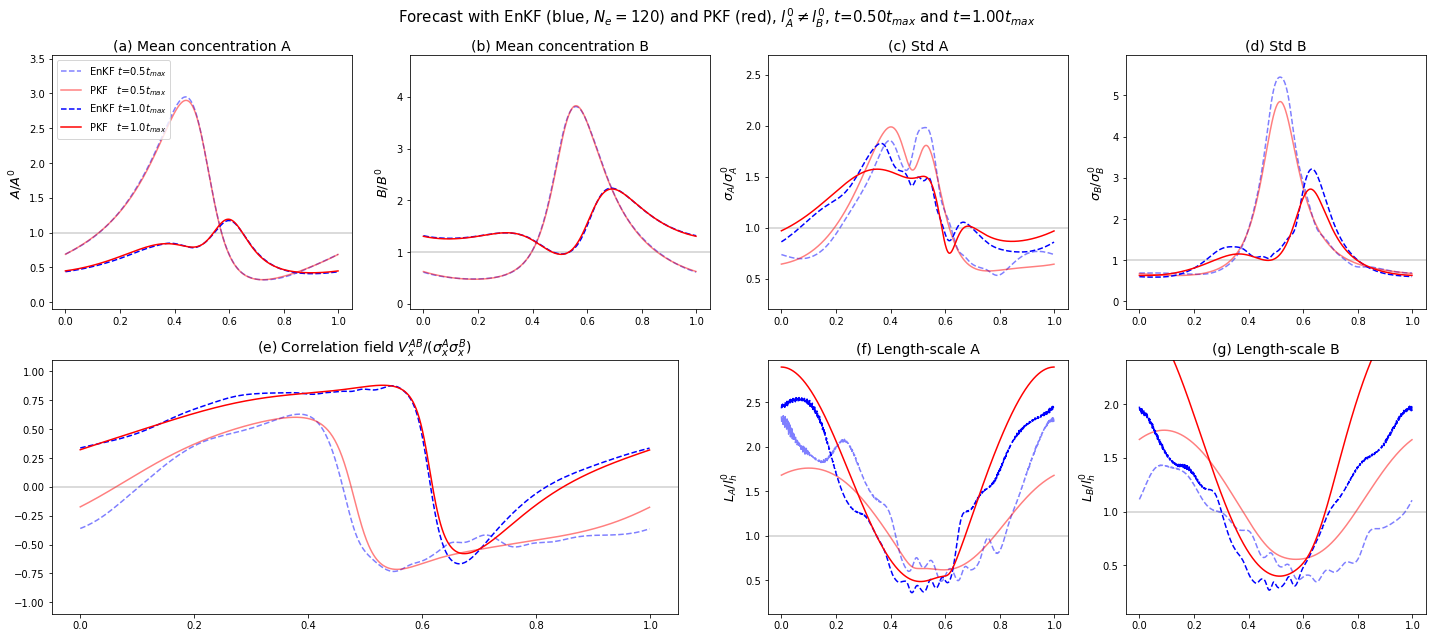

In [44]:
n_stops = 2

times = list(enkf_FCST.keys())
indexs = np.linspace(0, len(times)-1,n_stops+1).astype(int)[1:]

times2 = [times[index] for index in indexs]
alphas = [0.5,1]

title_FCST = r'Forecast with EnKF (blue, $N_e ={}$) and PKF (red), $l^0_A \neq l^0_B$, $t$={:.2f}'.format(ensemble_size, times2[0]/times[-1]) +\
    r'$t_{max}$' +' and $t$={:.2f}'.format(times2[1]/times[-1]) \
    + r'$t_{max}$'
fig_FCST = make_plot2(times2[:2],alphas, enkf_FCST, pkf_FCST,False,subplot_lims_FCST, False, title_FCST);
fig_FCST.savefig(f'../../figures/Nx{Nx}/alternative_pkf_formulation_forecast_Nx{Nx}_l0A_neq_l0B.png')

### Data assimilation experiment

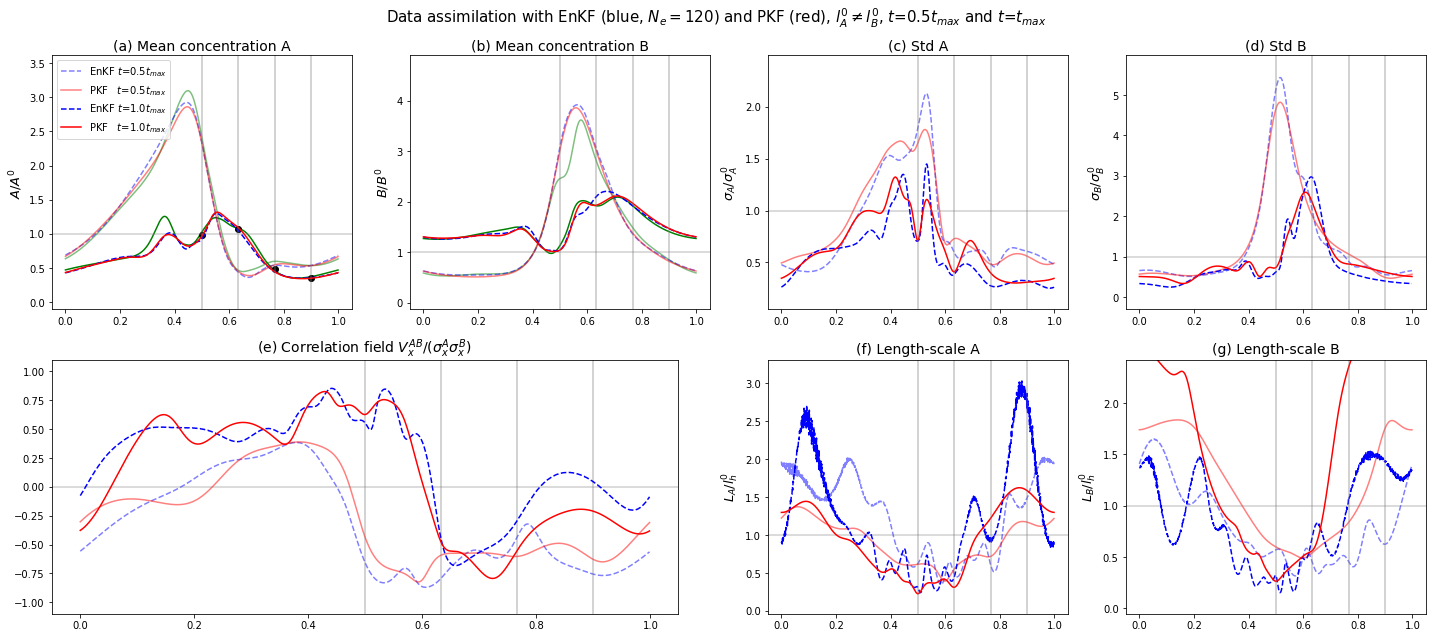

In [45]:
n_stops = 2

times = list(enkf_DA.keys())
indexs = np.linspace(0, len(times)-1,n_stops+1).astype(int)[1:]

times2 = [times[index] for index in indexs]
alphas = [0.5,1]

title_DA = r'Data assimilation with EnKF (blue, $N_e ={}$) and PKF (red), $l^0_A \neq l^0_B$, $t$={:.1f}'.format(ensemble_size, times2[0]/times[-1]) +\
    r'$t_{max}$' +' and $t$='.format(times2[1]/times[-1]) \
    + r'$t_{max}$'
fig_DA = make_plot2(times2[:2],alphas,enkf_DA, pkf_DA, True,subplot_lims_DA,True, title_DA);
fig_DA.savefig(f'../../figures/Nx{Nx}/alternative_pkf_formulation_data_assimilation_exp_Nx{Nx}_with_NR_l0A_neq_l0B.png')